In [3]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
wine_quality = fetch_ucirepo(id=186)

# Pre-processing
df = wine_quality.data.original


def categorize_quality(quality):
    if quality < 7:
        return 'low'
    else:
        return 'high'


df['quality_category'] = df['quality'].apply(categorize_quality)

red = df[df['color'] == 'red']
white = df[df['color'] == 'white']

df_array = [red, white, df]
wine_names = ['red', 'white', 'red and white']

In [7]:
df_names = ['Red Wine', 'White Wine', 'Combined Wine']


def confusion_matrix_plot(y_test, y_pred, clf, model):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=clf.classes_)

    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for DataFrame {model.__class__.__name__}')
    plt.show()


def optimized_folds(model, X, y):
    best_score = 0
    best_folds = 0

    for folds in np.arange(2, 11):
        scores = cross_val_score(model, X, y, cv=folds, scoring='f1_macro')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_folds = folds

    print(f"Best Folds: {best_folds} | Best Score: {best_score}", end=" | ")
    return best_folds

              precision    recall  f1-score   support

        high       0.71      0.26      0.38        47
         low       0.88      0.98      0.93       273

    accuracy                           0.88       320
   macro avg       0.80      0.62      0.65       320
weighted avg       0.86      0.88      0.85       320



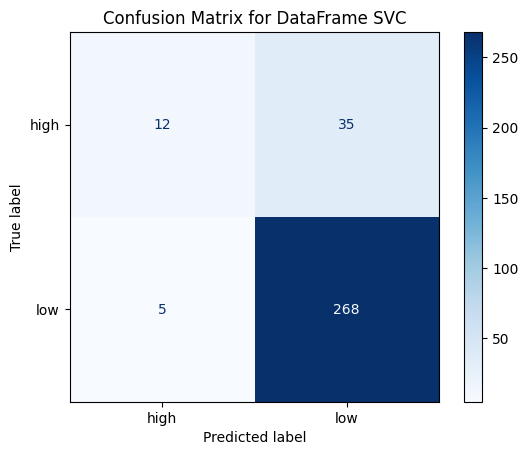

              precision    recall  f1-score   support

        high       0.75      0.34      0.47       227
         low       0.83      0.97      0.89       753

    accuracy                           0.82       980
   macro avg       0.79      0.65      0.68       980
weighted avg       0.81      0.82      0.79       980



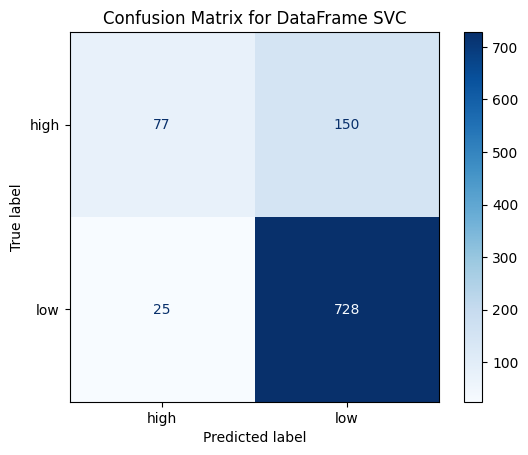

              precision    recall  f1-score   support

        high       0.71      0.27      0.39       252
         low       0.85      0.97      0.91      1048

    accuracy                           0.84      1300
   macro avg       0.78      0.62      0.65      1300
weighted avg       0.82      0.84      0.81      1300



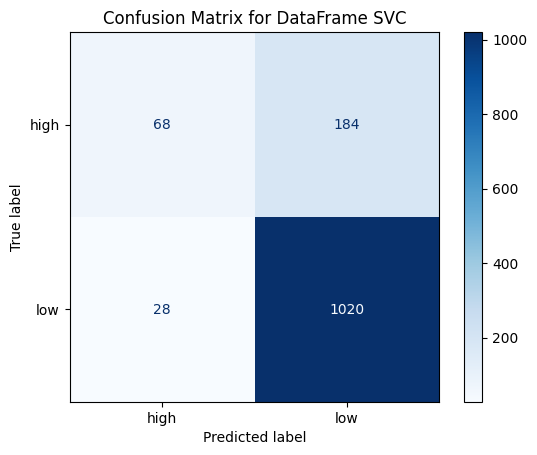

In [9]:
for wine in df_array:
    X = wine.drop(['quality', 'quality_category', 'color'], axis=1)
    y = wine['quality_category']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.2)

    svm = SVC(random_state=42, kernel='rbf')
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    print(classification_report(y_test, y_pred))
    confusion_matrix_plot(y_test, y_pred, svm, svm)